# **Importance des caractéristiques**

✔ 4.1. [**Graphiques de dépendance partielle et d'espérance conditionnelle individuelle**](https://scikit-learn.org/stable/modules/partial_dependence.html)

* ✔ 4.1.1. Graphiques de dépendance partielle (PDP)
* ✔ 4.1.2. Diagramme d'espérance conditionnelle individuelle (ICE)
* ✔ 4.1.3. Définition mathématique
* ✔ 4.1.4. Méthodes de calcul

✔ 4.2. [**Importance des caractéristiques de permutation**](https://scikit-learn.org/stable/modules/permutation_importance.html)

* ✔ 4.2.1. Aperçu de l'algorithme d'importance de permutation
* ✔ 4.2.2. Relation avec l'importance basée sur les impuretés dans les arbres
* ✔ 4.2.3. Valeurs trompeuses sur les caractéristiques fortement corrélées

# PDP et ICE

## Chargement, etc

### Chargement et nettoyage des données

In [1]:
from pepper_commons import get_data
from seattle_commons import clean_dataset, drop_my_outliers
data = get_data()                                    # load data from CSV file
data, not_compliant, outliers = clean_dataset(data)  # drop outliers identified by Seattle
data, my_outliers = drop_my_outliers(data)           # drop my own outliers (18)
# display(data)

✔ _data loaded
✔ struct loaded


### Partition *résidentiel* vs. *non résidentiel*

In [2]:
from seattle_commons import get_family_buildings, get_business_buildings
r_data = get_family_buildings(data)                # residential subset
nr_data = get_business_buildings(data)             # non residential subset

### Config 14 : $\ln{e} = f(\ln{a}, (\tilde{a}_{u_k}))$

In [3]:
config_name = "{(_a_u_k)_k, log(a) : log(e)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); display(ml_data)

,_ua_Multifamily Housing,_ua_Office,_ua_Parking,_ua_Non-Refrigerated Warehouse,_ua_Hotel,_ua_Other,_ua_Retail Store,_ua_Hospital (General Medical & Surgical),_ua_Senior Care Community,_ua_College/University,...,_ua_Other - Technology/Science,_ua_Convenience Store without Gas Station,_ua_Fast Food Restaurant,_ua_Swimming Pool,_ua_Outpatient Rehabilitation/Physical Therapy,_ua_Single Family Home,_ua_Energy/Power Station,_ua_Vocat,log(a),log(e)
id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.390012,15.793246
2,0.0,0.000000,0.145453,0.0,0.809918,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.547964,15.942305
3,0.0,0.000000,0.000000,0.0,0.791220,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.770628,18.100297
5,0.0,0.000000,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.023861,15.731636
8,0.0,0.000000,0.387339,0.0,0.703070,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.075850,16.466822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50221,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.812523,13.745176
50223,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.680344,13.764508
50224,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.484709,15.567471


#### Partition

In [4]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

##### Recherche Lasso en grille intégrée

best alpha : 0.0009717841964281194
    train score : 0.7902049932962582
     test score : 0.7469163039944295
3-CV mean score : 0.7184488583498306
 3-CV std score : 0.04528132984759237


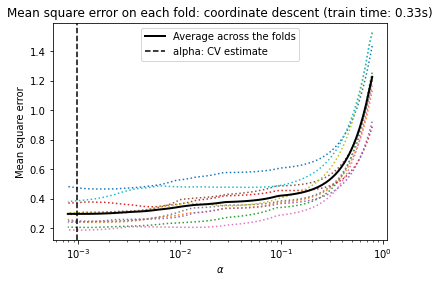

In [5]:
from pepper_skl_commons import builtin_best_lasso_cv_search

Xy = X_train, X_test, y_train, y_test
est = builtin_best_lasso_cv_search(Xy, X, y)

# PDP

Computing partial dependence plots...
done in 0.769s


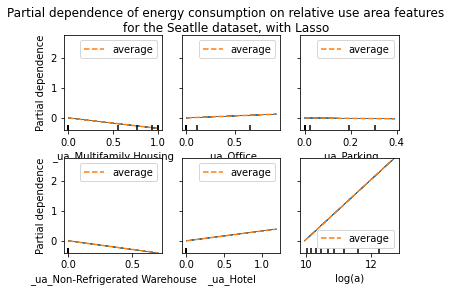

In [7]:
import time
from sklearn.inspection import PartialDependenceDisplay

common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "centered": True,
    "random_state": 0,
}

print("Computing partial dependence plots...")
tic = time.time()
display = PartialDependenceDisplay.from_estimator(
    est,
    X_train,
    features=[
        "_ua_Multifamily Housing",
        "_ua_Office",
        "_ua_Parking",
        "_ua_Non-Refrigerated Warehouse",
        "_ua_Hotel",
        "log(a)"],
    kind="both",
    **common_params,
)

print(f"done in {time.time() - tic:.3f}s")
display.figure_.suptitle(
    "Partial dependence of energy consumption on relative use area features\n"
    "for the Seatlle dataset, with Lasso"
)
display.figure_.subplots_adjust(hspace=0.3)